#  Algorithmic Biases in Computer Vision: How CelebA Encodes and Reproduces Gender Stereotypes in Appearance



To audit algorithmic biases, spatial attention map using grad-cam was created after fining-turning pretrained ResNet-18
*   ResNet-18
*   Grad-CAM





## 0. Set-up


---


In [ ]:
pip install torchinfo

In [ ]:
!pip install -q torch torchvision torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 54.8 MB/s eta 0:00:00


In [ ]:
pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-xketzkky
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-xketzkky
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=43670 sha256=b5a4e5fa6fb9fad54d4fdc34147a07db829fbf11793c3e1d3be607887a494228
  Stored in directory: /tmp/pip-ephem-wheel-cache-cs0tlc6p/wheels/a0/4d/c8/0502c44e32030c99ffab1b98075308a1ef9829c1835537afc6
Successfully built grad-cam


In [ ]:
import os, json, shutil, zipfile

api_token = {"username": "uniwmak12", "key": "009b11a3b7d2d8984fe4baac7b90a791"}
_kaggle_dir = "/root/.config/kaggle"
os.makedirs(_kaggle_dir, exist_ok=True)
with open(os.path.join(_kaggle_dir, "kaggle.json"), "w") as f:
    json.dump(api_token, f)
os.chmod(os.path.join(_kaggle_dir, "kaggle.json"), 0o600)

## 1. Data loading and preprocessing


---
The images were center-cropped and resized to 224 × 224 pixels to fit the pretrained ResNet input, and normalized to [–1, 1].

In [ ]:
# Imports
import copy
import numpy as np
import pandas as pd
from PIL import Image
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ExponentialLR, LambdaLR
from torchvision import models
from tqdm.auto import tqdm

import torchvision.transforms as T
import matplotlib.pyplot as plt


from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    MetricFrame,
)
from sklearn.metrics import (
    average_precision_score,
    balanced_accuracy_score,
    accuracy_score,
)

from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:
# Use GPU
device = torch.device("cuda")
print(f"Running on: {device}")

Running on: cuda


In [ ]:
# Download CelebA via Kaggle
api = KaggleApi()
api.authenticate()

download_dir = "celeba_data"
os.makedirs(download_dir, exist_ok=True)
api.dataset_download_files("jessicali9530/celeba-dataset", path=download_dir, unzip=True)

img_extract_path = os.path.join(download_dir, "img_align_celeba")

# Handle possible nested folder structure
_nested_path = os.path.join(img_extract_path, "img_align_celeba")
if os.path.isdir(_nested_path):
    print("Detected nested folder. Flattening...")
    for fname in os.listdir(_nested_path):
        src = os.path.join(_nested_path, fname)
        dst = os.path.join(img_extract_path, fname)
        if not os.path.exists(dst):
            shutil.move(src, dst)
    if not os.listdir(_nested_path):
        os.rmdir(_nested_path)

image_files = [f for f in os.listdir(img_extract_path) if f.endswith(".jpg")]
print("Total extracted images:", len(image_files))

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
Detected nested folder. Flattening...
Total extracted images: 202599


In [ ]:
# Dataset & DataLoader
class CelebASmileDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, target_attr="Attractive", protected_attr="Male"):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.target_attr = target_attr
        self.protected_attr = protected_attr

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.img_dir, row["image_id"])) .convert("RGB")
        if self.transform:
            img = self.transform(img)
        y = float(row[self.target_attr])

        # 4-way protected group: 0=YoungF, 1=YoungM, 2=OldF, 3=OldM
        age_label    = int(row["Young"] == 0)   # 1=old, 0=young
        gender_label = int(row["Male"]  == 1)   # 1=male, 0=female
        gid = age_label * 2 + gender_label
        return img, y, gid

transform = T.Compose([
    T.CenterCrop(178),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.5] * 3, [0.5] * 3),
])

In [ ]:
def Load_data(target_label="Smiling"):
    attr_path = os.path.join(download_dir, "list_attr_celeba.csv")
    df = pd.read_csv(attr_path)
    df[target_label] = ((df[target_label] + 1) // 2).astype("float32")

    # Ensure Young and Male are 0/1 as well (CelebA gives -1/1)
    for _col in ["Young", "Male"]:
        if _col in df.columns:
            df[_col] = ((df[_col] + 1) // 2).astype("int64")

    df = df[df["image_id"].isin(image_files)].reset_index(drop=True)

    full_dataset = CelebASmileDataset(df, img_dir=img_extract_path, transform=transform, target_attr=target_label)

    train_len = int(0.8 * len(full_dataset))
    val_len = int(0.1 * len(full_dataset))
    test_len = len(full_dataset) - train_len - val_len

    train_set, val_set, test_set = random_split(
        full_dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42)
    )

    dl_train = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    dl_val = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
    dl_test = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

    return dl_train, dl_val, dl_test

## 2. Fine-tune Pretrained ResNet-18


---

In [ ]:
def make_resnet18(*,
                  fc_dropout: float = 0.5,
                  layer4_dropout2d: float | None = None,
                  weights: str = "IMAGENET1K_V1",
                  trainable_parts: tuple[str, ...] = ("layer4", "fc")) -> nn.Module:
    """
    Build a ResNet18 with optional Dropout2d after layer4 and Dropout in the FC head.
    `trainable_parts` controls which submodules are trainable via name substring match.
    """
    model = models.resnet18(weights=weights)

    # Dropout on conv features after the whole layer4 block
    if layer4_dropout2d is not None and layer4_dropout2d > 0:
        model.layer4 = nn.Sequential(
            model.layer4,
            nn.Dropout2d(p=layer4_dropout2d),
        )

    # FC head with dropout
    in_f = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=fc_dropout),
        nn.Linear(in_f, 1),
    )

    # Freeze everything except requested parts
    if trainable_parts is not None:
        allow = list(trainable_parts)
        # Make sure 'fc' is included if you want the head trainable
        model = freeze_all_except(model, allow)

    return model

In [ ]:
# Group labels and pretty table
GROUP_NAMES = {0: "YoungF", 1: "YoungM", 2: "OldF", 3: "OldM"}
GROUP_ORDER = ["YoungF", "YoungM", "OldF", "OldM"]

def _fmt(x):
    import numpy as np
    return "nan" if x is None or (isinstance(x, float) and np.isnan(x)) else f"{x:.4f}"

def print_group_table(acc_by_group: dict, ap_by_group: dict, title: str):
    print(f"\n{title}")
    print(f"{'Group':<10}{'Accuracy':>12}{'AP':>12}")
    for name in GROUP_ORDER:
        acc = acc_by_group.get(name, float("nan"))
        ap  = ap_by_group.get(name,  float("nan"))
        print(f"{name:<10}{_fmt(acc):>12}{_fmt(ap):>12}")

## 3. Build Training Piplines


---
This study fine-tuned the network with binary cross-entropy with logits, optimised using Adam. Learning-rate decay was applied per epoch via exponential decay with the factor of 0.95.

In [ ]:
def train_model(
    model, trainloader, valloader, *,
    epochs=10, lr=1e-4, device=device,
    decay_gamma=0.95,
    per_step_decay=False
):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam((p for p in model.parameters() if p.requires_grad), lr=lr)

    # Scheduler: exponential decay
    if per_step_decay:
        # decay every optimizer step (batch): lr_t = lr * gamma^t
        scheduler = LambdaLR(optimizer, lr_lambda=lambda step: decay_gamma ** step)
    else:
        # decay every epoch: lr_e = lr * gamma^e
        scheduler = ExponentialLR(optimizer, gamma=decay_gamma)

    best_wts, best_ap = copy.deepcopy(model.state_dict()), 0.0

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0

        pbar = tqdm(trainloader, desc=f"Train e{epoch}/{epochs}", leave=False)
        for x, y, _ in pbar:
            x, y = x.to(device), y.float().to(device)
            optimizer.zero_grad()
            loss = criterion(model(x).squeeze(1), y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if per_step_decay:
                scheduler.step()  # decay each batch

            pbar.set_postfix(loss=f"{running_loss:.3f}", lr=f"{optimizer.param_groups[0]['lr']:.2e}")

        # decay each epoch (if not per-step)
        if not per_step_decay:
            scheduler.step()

        # Validation (no plots during training)
        metrics = evaluate_model(
            model, valloader, device=device,
            plot_group_averages=False, plot_gradcam=False
        )
        cur_lr = optimizer.param_groups[0]['lr']
        print(
            f"Epoch {epoch}: lr={cur_lr:.2e} | loss={running_loss:.4f} | "
            f"Top-1 err={metrics['top1_err']*100:5.2f}% | "
            f"AP={metrics['ap']:.4f} | BalAcc={metrics['bal_acc']:.4f} | "
            f"DP_gap={metrics['dp_gap']:.4f} | EO_gap={metrics['eo_gap']:.4f} | "
            f"Worst={metrics['worst_group_label']}@{metrics['worst_group_accuracy']:.4f}"
        )
        print_group_table(metrics["accuracy_by_group"], metrics["ap_by_group"],
                          title="VAL per-group (Accuracy & AP)")

        if metrics["ap"] > best_ap:
            best_ap, best_wts = metrics["ap"], copy.deepcopy(model.state_dict())

    model.load_state_dict(best_wts)
    print(f"Training finished – best AP = {best_ap:.4f}")
    return model

## 4. Build Evaluation Piplines


---
The top-K images with the highest predicted scores (e.g., K=64) are selected, and Grad-CAM is applied to the final convolutional block before global average pooling, with the attractiveness logit as the target.

To evaluate performance, accuracy and average precision are calculated by subgroups.


In [ ]:
def evaluate_model(
    model, loader, device=device,
    plot_group_averages=True, plot_gradcam=True,
    cam_samples_per_group: int = 64,
    cam_subset: str = "topk",
    cam_threshold: float = 0.5
):
    """
    Computes metrics and visualisations.
    Grad-CAM: compute per-image CAMs within each subgroup, average them, and
    overlay on that subgroup's average face.
    """
    model.eval()
    probs_all, labels_all, groups_all = [], [], []

    # For group-average faces (in pixel space [0,1])
    sum_by_group, count_by_group = {}, {}

    # Keep a pool of candidate inputs for CAM (normalized model inputs)
    cam_pool = defaultdict(list)

    # Pass over data: metrics + stash samples
    with torch.no_grad():
        for x, y, g in loader:
            # Copy for visualization averages
            x_vis = (x.detach().cpu() * 0.5 + 0.5).clamp(0, 1)
            g_cpu = g.detach().cpu()

            # Forward
            x_dev = x.to(device)
            logits = model(x_dev).squeeze(1)
            probs  = torch.sigmoid(logits).detach().cpu()

            # Collect averages + stash CAM candidates
            B = x_vis.size(0)
            for i in range(B):
                gid_i = int(g_cpu[i].item())

                if gid_i not in sum_by_group:
                    sum_by_group[gid_i] = torch.zeros_like(x_vis[i])
                    count_by_group[gid_i] = 0
                sum_by_group[gid_i] += x_vis[i]
                count_by_group[gid_i] += 1

                if len(cam_pool[gid_i]) < 4 * cam_samples_per_group:
                    cam_pool[gid_i].append({
                        "x": x[i].unsqueeze(0).cpu(),          # Normalised input ([-1,1])
                        "p": float(probs[i].item()),
                        "y": int(y[i].item()),
                    })

            probs_all.append(probs)
            labels_all.append(y)
            groups_all.append(g)

    # Metrics
    probs  = torch.cat(probs_all)
    labels = torch.cat(labels_all).float()
    groups = torch.cat(groups_all).int()
    preds  = (probs >= 0.5).int()

    accuracy = (preds == labels.int()).float().mean().item()
    top1_err = 1.0 - accuracy
    ap       = average_precision_score(labels.numpy(), probs.numpy())
    bal_acc  = balanced_accuracy_score(labels.numpy().astype(int), preds.numpy().astype(int))

    dp_gap = abs(demographic_parity_difference(
        y_true=labels.numpy().astype(int),
        y_pred=preds.numpy().astype(int),
        sensitive_features=groups.numpy(),
    ))
    eo_gap = abs(equalized_odds_difference(
        y_true=labels.numpy().astype(int),
        y_pred=preds.numpy().astype(int),
        sensitive_features=groups.numpy(),
    ))

    mf_acc = MetricFrame(
        metrics=accuracy_score,
        y_true=labels.numpy().astype(int),
        y_pred=preds.numpy().astype(int),
        sensitive_features=groups.numpy(),
    )
    acc_by_group_series = mf_acc.by_group
    worst_group_idx = int(acc_by_group_series.idxmin())
    worst_group_accuracy = float(acc_by_group_series.min())
    accuracy_by_group = {GROUP_NAMES[int(k)]: float(v)
                         for k, v in acc_by_group_series.to_dict().items()}

    # Per-group AP
    ap_by_group = {}
    g_np, y_np, p_np = groups.numpy(), labels.numpy(), probs.numpy()
    for gid in sorted(np.unique(g_np).tolist()):
        mask = (g_np == gid)
        y_g, p_g = y_np[mask], p_np[mask]
        ap_by_group[GROUP_NAMES[int(gid)]] = float("nan") if len(np.unique(y_g)) < 2 else float(average_precision_score(y_g, p_g))

    # Show subgroup average faces
    if plot_group_averages and len(sum_by_group) > 0:
        gids_sorted = sorted(sum_by_group.keys())
        plt.figure(figsize=(3 * len(gids_sorted), 3))
        for idx, gid in enumerate(gids_sorted, 1):
            avg_img_vis = (sum_by_group[gid] / max(count_by_group[gid], 1)).permute(1, 2, 0).numpy()
            ax = plt.subplot(1, len(gids_sorted), idx)
            ax.imshow(avg_img_vis)
            ax.set_title(GROUP_NAMES.get(int(gid), str(gid)))
            ax.axis("off")
        plt.tight_layout(); plt.show()

    #  Avg-of-CAMs per subgroup
    if plot_gradcam and len(sum_by_group) > 0:
        target_layers = [model.layer4[-1]]  # ResNet18 last BasicBlock
        gids_sorted = sorted(sum_by_group.keys())
        plt.figure(figsize=(3 * len(gids_sorted), 3))

        def select_subset(pool, mode, k, thr):
            if not pool:
                return []
            if mode == "topk":
                pool = sorted(pool, key=lambda d: d["p"], reverse=True)[:k]
            elif mode == "tp":
                pool = [d for d in pool if (d["y"] == 1 and d["p"] >= thr)][:k]
            elif mode == "fn":
                pool = [d for d in pool if (d["y"] == 1 and d["p"] <  thr)][:k]
            elif mode == "fp":
                pool = [d for d in pool if (d["y"] == 0 and d["p"] >= thr)][:k]
            elif mode == "tn":
                pool = [d for d in pool if (d["y"] == 0 and d["p"] <  thr)][:k]
            else:
                pool = pool[:k]
            return pool

        with torch.enable_grad():  # Enable grads only for CAM computation
            cam = GradCAM(model=model, target_layers=target_layers)
            for idx, gid in enumerate(gids_sorted, 1):
                pool = select_subset(cam_pool.get(gid, []), cam_subset, cam_samples_per_group, cam_threshold)
                if not pool:
                    continue

                batch = torch.cat([d["x"] for d in pool], dim=0).to(device)
                targets = [ClassifierOutputTarget(0)] * batch.size(0)
                cams = cam(input_tensor=batch, targets=targets)
                avg_cam = cams.mean(axis=0)

                avg_img_vis = (sum_by_group[gid] / max(count_by_group[gid], 1)).permute(1, 2, 0).numpy().astype(np.float32)
                overlay = show_cam_on_image(avg_img_vis, avg_cam, True)

                ax = plt.subplot(1, len(gids_sorted), idx)
                label_map = {"all": "All", "topk": "Top-K", "tp": "TP", "fn": "FN", "fp": "FP", "tn": "TN"}
                ax.imshow(overlay)
                ax.set_title(f"{GROUP_NAMES.get(gid, gid)} Avg-CAM ({label_map.get(cam_subset, cam_subset)})")
                ax.axis("off")

        plt.tight_layout(); plt.show()

    return {
        "top1_err": top1_err,
        "ap": ap,
        "bal_acc": bal_acc,
        "dp_gap": dp_gap,
        "eo_gap": eo_gap,
        "worst_group_accuracy": worst_group_accuracy,
        "worst_group_label": GROUP_NAMES.get(worst_group_idx, worst_group_idx),
        "accuracy_by_group": accuracy_by_group,
        "ap_by_group": ap_by_group,
    }

## 5. Freeze all layers except for last and FC layers


---

To prevent overfitting, dropout & freezing were applied

In [ ]:
# Helper for freezing layers
def freeze_all_except(model: nn.Module, allow: list[str]):
    for name, p in model.named_parameters():
        p.requires_grad = any(substr in name for substr in allow)
    return model

def print_banner(msg):
    print("\n" + "=" * 60 + f"\n{msg}\n" + "=" * 60)

## 6. Run the code


---


RESNET18 | Target Attribute: Attractive | layer4+fc fine-tune


Train e1/10:   0%|          | 0/2533 [00:00<?, ?it/s]

Epoch 1: lr=9.50e-05 | loss=1029.6949 | Top-1 err=17.80% | AP=0.9167 | BalAcc=0.8211 | DP_gap=0.7209 | EO_gap=0.5642 | Worst=OldF@0.7658

VAL per-group (Accuracy & AP)
Group         Accuracy          AP
YoungF          0.8289      0.9533
YoungM          0.7711      0.7947
OldF            0.7658      0.7555
OldM            0.9127      0.3744


Train e2/10:   0%|          | 0/2533 [00:00<?, ?it/s]

Epoch 2: lr=9.02e-05 | loss=912.5560 | Top-1 err=17.41% | AP=0.9219 | BalAcc=0.8255 | DP_gap=0.7231 | EO_gap=0.6111 | Worst=YoungM@0.7748

VAL per-group (Accuracy & AP)
Group         Accuracy          AP
YoungF          0.8282      0.9565
YoungM          0.7748      0.8020
OldF            0.7891      0.7665
OldM            0.9230      0.4015


Train e3/10:   0%|          | 0/2533 [00:00<?, ?it/s]

Epoch 3: lr=8.57e-05 | loss=794.9312 | Top-1 err=17.71% | AP=0.9161 | BalAcc=0.8228 | DP_gap=0.7254 | EO_gap=0.5993 | Worst=YoungM@0.7677

VAL per-group (Accuracy & AP)
Group         Accuracy          AP
YoungF          0.8255      0.9518
YoungM          0.7677      0.7900
OldF            0.7816      0.7531
OldM            0.9287      0.4207


Train e4/10:   0%|          | 0/2533 [00:00<?, ?it/s]

Epoch 4: lr=8.15e-05 | loss=553.2081 | Top-1 err=19.70% | AP=0.9041 | BalAcc=0.8040 | DP_gap=0.6589 | EO_gap=0.6036 | Worst=YoungM@0.7508

VAL per-group (Accuracy & AP)
Group         Accuracy          AP
YoungF          0.7982      0.9437
YoungM          0.7508      0.7726
OldF            0.7734      0.7033
OldM            0.9223      0.3828


Train e5/10:   0%|          | 0/2533 [00:00<?, ?it/s]

Epoch 5: lr=7.74e-05 | loss=274.8120 | Top-1 err=20.10% | AP=0.8937 | BalAcc=0.7984 | DP_gap=0.6846 | EO_gap=0.4892 | Worst=YoungM@0.7372

VAL per-group (Accuracy & AP)
Group         Accuracy          AP
YoungF          0.8043      0.9375
YoungM          0.7372      0.7361
OldF            0.7596      0.7076
OldM            0.9060      0.3540


Train e6/10:   0%|          | 0/2533 [00:00<?, ?it/s]

Epoch 6: lr=7.35e-05 | loss=148.2885 | Top-1 err=19.23% | AP=0.8972 | BalAcc=0.8073 | DP_gap=0.7010 | EO_gap=0.5458 | Worst=YoungM@0.7523

VAL per-group (Accuracy & AP)
Group         Accuracy          AP
YoungF          0.8110      0.9377
YoungM          0.7523      0.7495
OldF            0.7637      0.7167
OldM            0.9127      0.3764


Train e7/10:   0%|          | 0/2533 [00:00<?, ?it/s]

Epoch 7: lr=6.98e-05 | loss=106.0646 | Top-1 err=19.26% | AP=0.9001 | BalAcc=0.8069 | DP_gap=0.6710 | EO_gap=0.4681 | Worst=YoungM@0.7513

VAL per-group (Accuracy & AP)
Group         Accuracy          AP
YoungF          0.8119      0.9413
YoungM          0.7513      0.7657
OldF            0.7658      0.7187
OldM            0.9086      0.3840


Train e8/10:   0%|          | 0/2533 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd1e11e7a60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd1e11e7a60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 8: lr=6.63e-05 | loss=82.8786 | Top-1 err=19.69% | AP=0.8941 | BalAcc=0.8029 | DP_gap=0.6629 | EO_gap=0.4901 | Worst=YoungM@0.7502

VAL per-group (Accuracy & AP)
Group         Accuracy          AP
YoungF          0.8030      0.9367
YoungM          0.7502      0.7496
OldF            0.7699      0.7144
OldM            0.9092      0.3646


Train e9/10:   0%|          | 0/2533 [00:00<?, ?it/s]

Epoch 9: lr=6.30e-05 | loss=68.9775 | Top-1 err=19.87% | AP=0.8910 | BalAcc=0.8009 | DP_gap=0.6796 | EO_gap=0.4931 | Worst=YoungM@0.7419

VAL per-group (Accuracy & AP)
Group         Accuracy          AP
YoungF          0.8037      0.9335
YoungM          0.7419      0.7454
OldF            0.7672      0.7168
OldM            0.9111      0.3756


Train e10/10:   0%|          | 0/2533 [00:00<?, ?it/s]

Epoch 10: lr=5.99e-05 | loss=59.5110 | Top-1 err=19.32% | AP=0.8943 | BalAcc=0.8059 | DP_gap=0.6990 | EO_gap=0.4669 | Worst=YoungM@0.7525

VAL per-group (Accuracy & AP)
Group         Accuracy          AP
YoungF          0.8088      0.9364
YoungM          0.7525      0.7514
OldF            0.7644      0.7174
OldM            0.9134      0.3980
Training finished – best AP = 0.9219


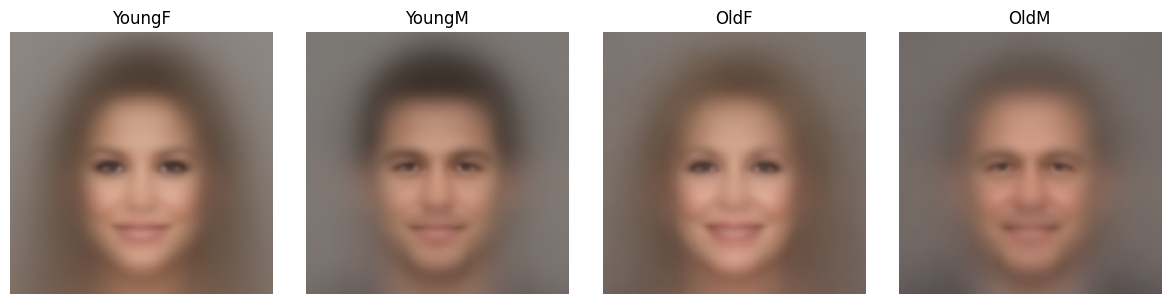

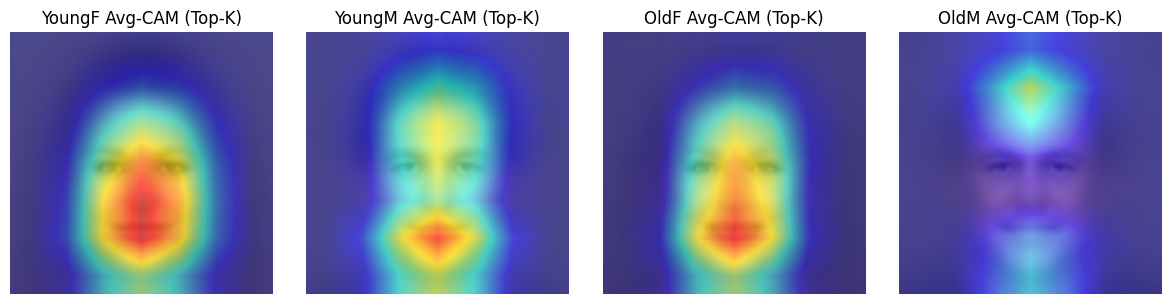


TEST per-group (Accuracy & AP)
Group         Accuracy          AP
YoungF          0.8124      0.9497
YoungM          0.7721      0.8002
OldF            0.8027      0.8028
OldM            0.9200      0.3977

Summary:
   architecture target attribute  top1_err       ap   bal_acc    dp_gap  \
0     resnet18       Attractive  0.181975  0.91618  0.817599  0.731144   

     eo_gap  worst_group_accuracy worst_group_label  
0  0.622663              0.772126            YoungM  


In [ ]:
epochs = 10
lr = 1e-4
attributes = ["Attractive"]  # "Smiling", "Wearing_Lipstick"

results = []
for attr in attributes:
    dl_train, dl_val, dl_test = Load_data(target_label=attr)

    print_banner(f"RESNET18 | Target Attribute: {attr} | layer4+fc fine-tune")

    # Build the model once per attribute
    model = make_resnet18(
        fc_dropout=0.5,
        layer4_dropout2d=0.2,
        weights="IMAGENET1K_V1",
        trainable_parts=("layer4", "fc")
    )

    model = train_model(model, dl_train, dl_val, epochs=epochs, lr=lr, device=device,decay_gamma=0.95, per_step_decay=False)

    # Evaluate + print per-group (Accuracy & AP)
    m = evaluate_model(model, dl_test, device=device,
                   plot_group_averages=True, plot_gradcam=True,
                   cam_samples_per_group=64, cam_subset="topk")

    print_group_table(m["accuracy_by_group"], m["ap_by_group"],
                      title="TEST per-group (Accuracy & AP)")

    # Drop dicts before storing a compact summary row
    m.pop("accuracy_by_group", None)
    m.pop("ap_by_group", None)

    results.append({
        "architecture": "resnet18",
        "target attribute": attr,
        **m,
    })

# Summary
summary_df = pd.DataFrame(results)
print("\nSummary:\n", summary_df)